# โหลด R packages และ ข้อมูล

In [6]:
if (!require("pacman")) install.packages("pacman")
pkgs = c('urca', 'vars', 'tidyverse', 'xts')
pacman::p_load(pkgs, character.only=TRUE)

In [ ]:
source("../R/oaeTS.R", encoding = "UTF-8")
year_now = 2563

options(
  repr.plot.width=10,
  repr.plot.height=6,
  repr.plot.res=300
)

In [7]:
price = readRDS('../data/price_rice_filled.rds')
var_names = colnames(price)
colnames(price) = str_replace(colnames(price), "_0", "")
price_xts = price %>% as.xts()
price_log = price
price_log[, startsWith(var_names, 'R')] = 
  price_log[, startsWith(var_names, 'R')] %>% log()
tail(price_log)

,RHFG,RHFG_NR,RHFG_BR,RHFG_SI,RHFG_SU,RHFG_UR,RWFG,RWFG_NS,RWFG_KP,RWFG_PC,RWFG_PS,RWFG_SH,RGFG,RGFG_UN,RGFG_SN,RGFG_KK,RGFG_MS,RGFG_KL,RHWS,RWWS,RGWS,RHXB,RWXB,RGXB,d_foodcrisis,d_pledge
"[370,]",9.698368,9.692952,9.714262,9.706560,9.694185,9.691531,8.977273,8.944681,8.945072,8.945724,8.937875,8.950403,9.606226,9.721126,9.760252,9.725437,9.682342,9.712206,10.48010,9.363266,10.55414,10.51180,9.451832,10.63612,0,0
"[371,]",9.569552,9.602112,9.587749,9.586789,9.613068,9.592742,8.972210,8.934060,8.933796,8.930362,8.908559,8.940629,9.547027,9.625294,9.653808,9.614605,9.585759,9.615805,10.41410,9.353301,10.52597,10.46402,9.443005,10.48123,0,0
"[372,]",9.512591,9.489864,9.497172,9.515101,9.517972,9.515322,8.949625,8.919988,8.897956,8.908830,8.911530,8.947416,9.520249,9.573037,9.624765,9.591991,9.574011,9.534740,10.34335,9.373970,10.48182,10.45268,9.467580,10.44256,0,0
"[373,]",9.529303,9.536762,9.530611,9.560716,9.536618,9.553363,8.956222,8.912204,8.910316,8.904630,8.925321,8.952347,9.565073,9.687009,9.627734,9.657715,9.660333,9.596759,10.34335,9.430571,10.48252,10.45108,9.517302,10.56501,0,0
"[374,]",9.540651,9.534234,9.535318,9.559729,9.526756,9.563248,9.007734,8.930230,8.927580,8.932873,8.937481,9.018211,9.597777,9.716375,9.594173,9.681156,9.715108,9.628590,10.34098,9.459665,10.46303,10.45344,9.561999,10.48222,0,0
"[375,]",9.542221,9.530871,9.536186,9.559543,9.524687,9.563384,9.021624,8.937446,8.930804,8.943172,8.940961,9.030471,9.603651,9.716712,9.581741,9.678454,9.717101,9.620330,10.33039,9.541303,10.39818,10.45488,9.668784,10.40334,0,0


In [79]:
y = price_log[, 'RHFG'] %>% window(start = 1990)

ur_adf = function(y, n_diff = 0, ...) {
  
  y = if(n_diff == 0) y else diff(y, n_diff)
  
  ur.trend = ur.df(y, type='trend', selectlags = "AIC", ...)
  ur.drift = ur.df(y, type='drift', selectlags = "AIC", ...)
  ur.none  = ur.df(y, type='none', selectlags = "AIC", ...)

  tstat.trend = ur.trend@teststat
  tstat.drift = ur.drift@teststat
  tstat.none  = ur.none@teststat

  cv.trend = ur.trend@cval
  cv.drift = ur.drift@cval
  cv.none  = ur.none@cval

  df_test = rbind(
    cbind(t(tstat.trend), cv.trend),
    cbind(t(tstat.drift), cv.drift),
    cbind(t(tstat.none) , cv.none)
  ) %>% 
  as.data.frame() %>%
  rownames_to_column("hypo") %>%
  mutate(
    result = ifelse(abs(statistic) >= abs(`5pct`), 'Reject', 'Accept'),
    level = paste0('d', n_diff)
  ) %>%
  filter(str_starts(hypo, 'tau')) %>%
  select(hypo, level, everything())
  
  return(df_test)
}

In [94]:
# y = price_log[, 'RHXB'] %>% window(start = 2007)
# y = price_log[, 'RHWS'] %>% window(start = 2007)
y = price_log[, 'RGXB'] %>% window(start = 2007)

rbind(ur_adf(y, 0), ur_adf(y, 1))

hypo,statistic,1pct,5pct,10pct,result,level
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
tau3,-2.8231544,-3.99,-3.43,-3.13,Accept,d0
tau2,-2.5364805,-3.46,-2.88,-2.57,Accept,d0
tau1,0.2963414,-2.58,-1.95,-1.62,Accept,d0
tau3,-8.4952862,-3.99,-3.43,-3.13,Reject,d1
tau2,-8.5211827,-3.46,-2.88,-2.57,Reject,d1
tau1,-8.5343629,-2.58,-1.95,-1.62,Reject,d1


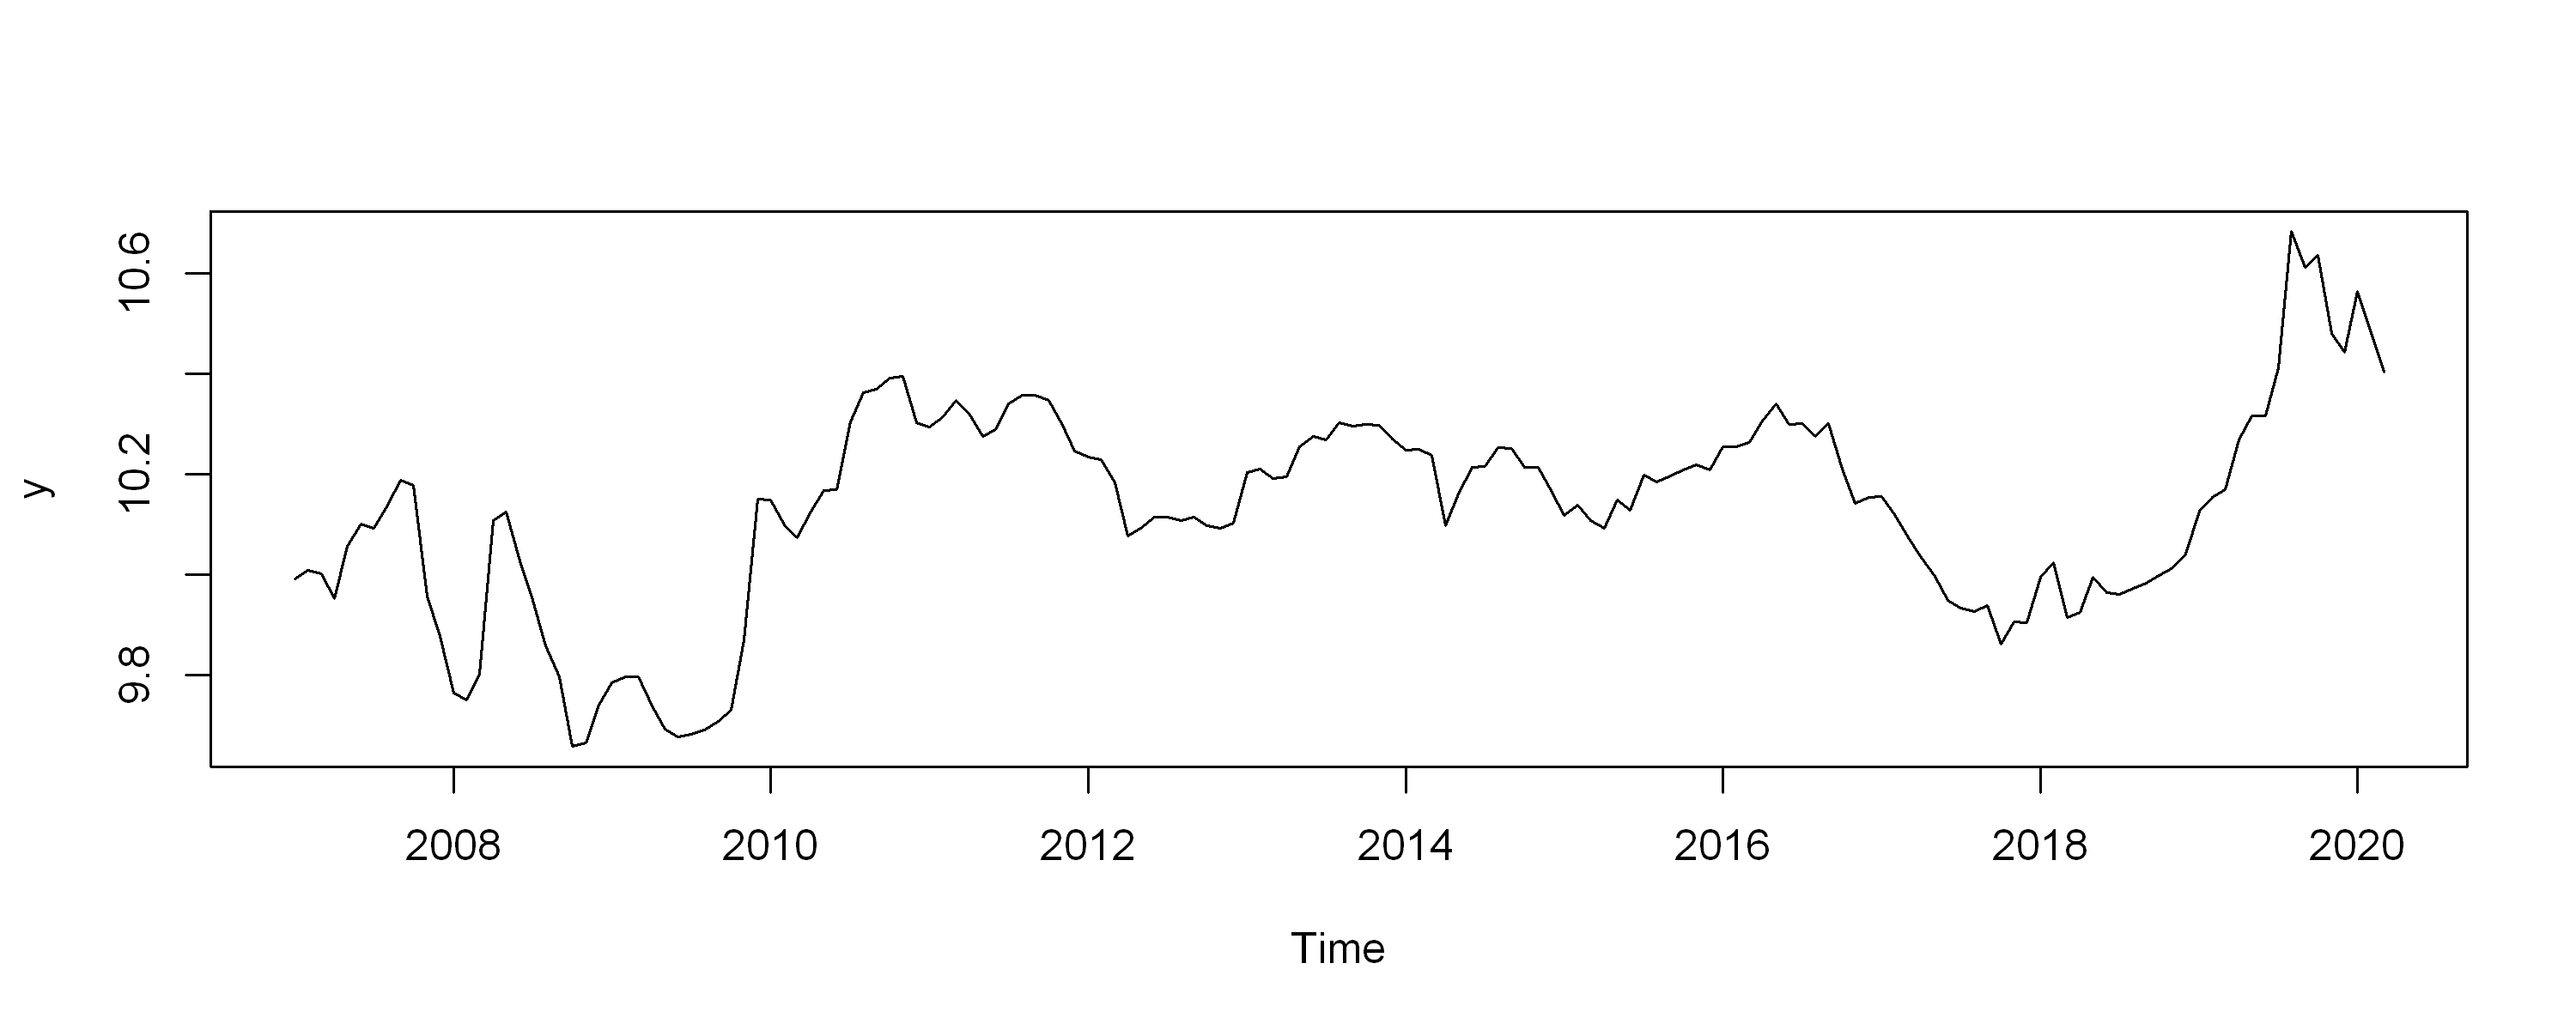

In [95]:
plot(y)